# Analysis: SINGLE Images Per Horse by Herd

This notebook analyzes the number of SINGLE images per horse grouped by herd to identify which herds have the lowest image counts per horse.

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
import yaml

# Set up plotting style
plt.style.use('default')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 8)

In [47]:
# Load configuration
with open('config.yml', 'r') as f:
    config = yaml.safe_load(f)

# Expand data_root path
data_root = Path(config['paths']['data_root']).expanduser()
print(f"Data root: {data_root}")

# Define file paths
manifest_file = Path(config['paths']['detected_manifest_file'].format(data_root=data_root))
horse_herds_file = Path(config['paths']['horse_herds_file'].format(data_root=data_root))

print(f"manifest file: {manifest_file}")
print(f"Horse herds file: {horse_herds_file}")

Data root: /Users/dleigh/google-drive/horseID Project/data
manifest file: /Users/dleigh/google-drive/horseID Project/data/horse_photos_manifest_detected.csv
Horse herds file: /Users/dleigh/google-drive/horseID Project/data/horse_herds.csv


In [48]:
# Check which files exist
files_to_check = [
    ('manifest',manifest_file),
    ('Horse herds', horse_herds_file)
]

for name, file_path in files_to_check:
    if file_path.exists():
        print(f"✓ {name}: {file_path} (exists)")
    else:
        print(f"✗ {name}: {file_path} (missing)")

✓ manifest: /Users/dleigh/google-drive/horseID Project/data/horse_photos_manifest_detected.csv (exists)
✓ Horse herds: /Users/dleigh/google-drive/horseID Project/data/horse_herds.csv (exists)


In [49]:
# Load the horse herds data
if horse_herds_file.exists():
    herds_df = pd.read_csv(horse_herds_file)
    print(f"Horse herds data loaded: {len(herds_df)} records")
    print(f"Columns: {list(herds_df.columns)}")
    print("\nFirst few rows:")
    print(herds_df.head())
else:
    print("Horse herds file not found - will use herd info from manifest if available")
    herds_df = None

Horse herds data loaded: 206 records
Columns: ['horse_name', 'herd', 'basename']

First few rows:
  horse_name              herd basename
0      Weebs  Home Barn/Farm 1    Weebs
1   George 2  Home Barn/Farm 1   George
2      Waldo  Home Barn/Farm 1    Waldo
3      Xerox  Home Barn/Farm 1    Xerox
4        Taz  Home Barn/Farm 1      Taz


In [50]:
# Load the main manifest file (prefer merged, fall back to detected)
manifest_df = pd.read_csv(manifest_file)
print(f"Loaded manifest: {len(manifest_df)} records")

if manifest_df is not None:
    print(f"\nColumns: {list(manifest_df.columns)}")
    print("\nFirst few rows:")
    print(manifest_df.head())

Loaded manifest: 5963 records

Columns: ['canonical_id', 'original_canonical_id', 'horse_name', 'email_date', 'message_id', 'original_filename', 'filename', 'date_added', 'num_horses_detected', 'last_merged_timestamp', 'status', 'size_ratio', 'normalized_horse_name', 'normalization_confidence', 'normalization_method', 'normalization_timestamp', 'bbox_x', 'bbox_y', 'bbox_width', 'bbox_height', 'segmentation_mask']

First few rows:
   canonical_id  original_canonical_id horse_name  email_date  \
0             1                      1   Guinness    20241023   
1             1                      1   Guinness    20241023   
2             1                      1   Guinness    20241023   
3             1                      1   Guinness    20241023   
4             1                      1   Guinness    20241023   

         message_id original_filename                       filename  \
0  197501aef3e81a5e      IMG_0847.jpg  197501aef3e81a5e-IMG_0847.jpg   
1  197501aef3e81a5e      IMG_08

In [51]:
# Check detection status distribution
if manifest_df is not None and 'num_horses_detected' in manifest_df.columns:
    print("Detection status distribution:")
    print(manifest_df['num_horses_detected'].value_counts())
    print(f"\nTotal SINGLE images: {len(manifest_df[manifest_df['num_horses_detected'] == 'SINGLE'])}")
else:
    print("No num_horses_detected column found - checking available columns...")
    if manifest_df is not None:
        print(f"Available columns: {list(manifest_df.columns)}")

Detection status distribution:
num_horses_detected
SINGLE      4614
MULTIPLE    1325
NONE          24
Name: count, dtype: int64

Total SINGLE images: 4614


In [56]:
single_images = manifest_df[manifest_df['num_horses_detected'] == 'SINGLE'].copy()
merged = herds_df.merge(single_images, left_on='basename', right_on='normalized_horse_name', how='outer', indicator=True)
merged['_merge'].value_counts()

_merge
both          4118
right_only     856
left_only       36
Name: count, dtype: int64

In [61]:
single_images_with_herd = merged[merged._merge == 'both']
images_per_horse = single_images_with_herd.groupby(['herd', 'normalized_horse_name']).size().reset_index(name='image_count')
images_per_horse

,herd,normalized_horse_name,image_count
0,Drew's,Anthem,11
1,Drew's,Aries,30
2,Drew's,Custer,11
3,Drew's,Dos,35
4,Drew's,Fry,30
...,...,...,...
165,Vernon's/Farm 5,Raffiki,20
166,Vernon's/Farm 5,Ramzee,16
167,Vernon's/Farm 5,Remy,36
168,Vernon's/Farm 5,Scotty,22


In [62]:
# Calculate statistics by herd
if images_per_horse is not None:
    herd_stats = images_per_horse.groupby('herd').agg({
        'image_count': ['count', 'mean', 'median', 'std', 'min', 'max'],
        'normalized_horse_name': 'count'
    }).round(2)
    
    # Flatten column names
    herd_stats.columns = ['num_horses', 'avg_images_per_horse', 'median_images_per_horse', 
                         'std_images_per_horse', 'min_images_per_horse', 'max_images_per_horse', 'num_horses_check']
    
    # Drop the check column
    herd_stats = herd_stats.drop('num_horses_check', axis=1)
    
    # Add total images per herd
    total_images_per_herd = single_images_with_herd.groupby('herd').size().reset_index(name='total_images')
    herd_stats = herd_stats.merge(total_images_per_herd.set_index('herd'), left_index=True, right_index=True)
    
    # Sort by average images per horse (ascending to see lowest first)
    herd_stats = herd_stats.sort_values('avg_images_per_horse')
    
    print("\n=== HERD STATISTICS (sorted by avg images per horse, lowest first) ===")
    print(herd_stats)
    
    # Identify herds with lowest averages
    lowest_avg = herd_stats['avg_images_per_horse'].min()
    lowest_herds = herd_stats[herd_stats['avg_images_per_horse'] == lowest_avg]
    
    print(f"\n\n=== HERDS WITH LOWEST AVERAGE IMAGES PER HORSE ({lowest_avg:.2f}) ===")
    print(lowest_herds)
    
    # Show bottom 5 herds
    print("\n\n=== TOP 5 HERDS NEEDING MORE IMAGES ===")
    print(herd_stats.head())
else:
    print("Cannot calculate herd statistics without images_per_horse data")
    herd_stats = None


=== HERD STATISTICS (sorted by avg images per horse, lowest first) ===
                       num_horses  avg_images_per_horse  \
herd                                                      
Others                          2                  9.00   
Mash/Farm 6                    10                 14.00   
Home Barn/Farm 1                6                 18.00   
Ponies                          4                 21.00   
Norman's/Oldtimers             19                 22.21   
Fjord/Farm8                     9                 22.44   
Vernon's/Farm 5                 8                 23.00   
Drew's                         12                 23.58   
Farm 3                         21                 24.05   
Farm 2                         19                 26.26   
Dwight's North/Farm 7          20                 27.20   
Gail's                         17                 27.29   
Dwight's West                  23                 28.91   

                       median_images_per_h

In [63]:
# Show examples of horses in the lowest-performing herds
if images_per_horse is not None and herd_stats is not None:
    print("\n=== EXAMPLES OF HORSES IN LOWEST-PERFORMING HERDS ===")
    
    # Get the bottom 3 herds
    bottom_herds = herd_stats.head(3).index.tolist()
    
    for herd in bottom_herds:
        herd_horses = images_per_horse[images_per_horse['herd'] == herd].sort_values('image_count')
        
        print(f"\n--- {herd} (avg: {herd_stats.loc[herd, 'avg_images_per_horse']:.2f} images/horse) ---")
        print(f"Total horses: {len(herd_horses)}")
        print(f"Total images: {herd_stats.loc[herd, 'total_images']}")
        print("\nHorses with fewest images:")
        print(herd_horses.head(10).to_string(index=False))
        
        if len(herd_horses) > 10:
            print(f"... and {len(herd_horses) - 10} more horses")


=== EXAMPLES OF HORSES IN LOWEST-PERFORMING HERDS ===

--- Others (avg: 9.00 images/horse) ---
Total horses: 2
Total images: 18

Horses with fewest images:
  herd normalized_horse_name  image_count
Others                Emmett            4
Others                Prince           14

--- Mash/Farm 6 (avg: 14.00 images/horse) ---
Total horses: 10
Total images: 140

Horses with fewest images:
       herd normalized_horse_name  image_count
Mash/Farm 6                 Ceelo            5
Mash/Farm 6                   Sky           10
Mash/Farm 6         Snickerdoodle           10
Mash/Farm 6                 Agave           12
Mash/Farm 6                Undigo           12
Mash/Farm 6                   Rio           13
Mash/Farm 6                Record           17
Mash/Farm 6               Jackson           20
Mash/Farm 6                   Obi           20
Mash/Farm 6                  Nora           21

--- Home Barn/Farm 1 (avg: 18.00 images/horse) ---
Total horses: 6
Total images: 108

Hor

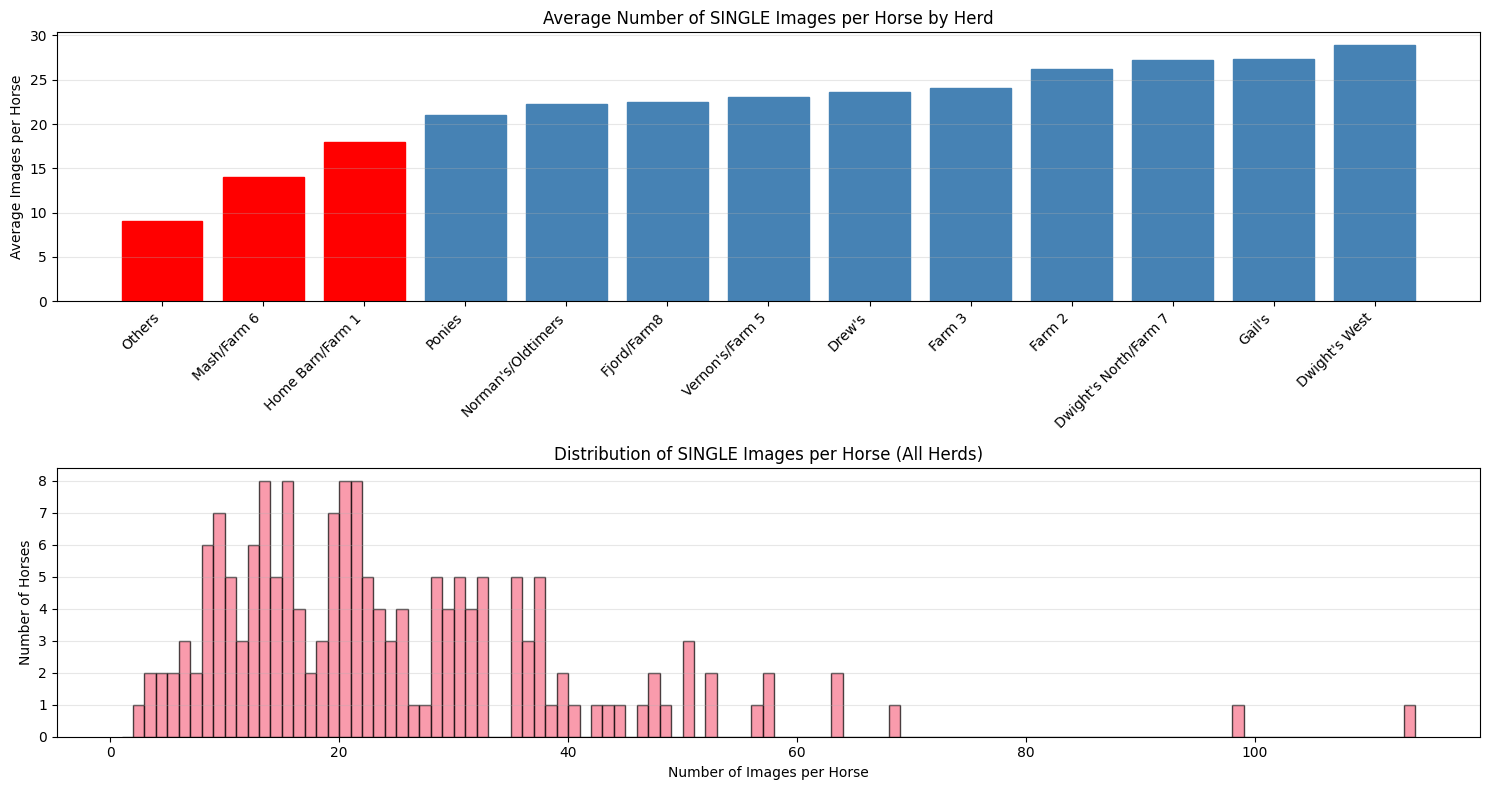


=== OVERALL SUMMARY ===
Total horses with SINGLE images: 170
Total SINGLE images: 4118
Average images per horse (overall): 24.22
Median images per horse (overall): 21.00
Number of herds: 13
Herd with lowest avg images/horse: Others (9.00)
Herd with highest avg images/horse: Dwight's West (28.91)


In [64]:
# Create visualizations
if herd_stats is not None:
    # Plot 1: Average images per horse by herd
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    
    # Sort by avg images per horse for better visualization
    herd_stats_sorted = herd_stats.sort_values('avg_images_per_horse')
    
    bars = plt.bar(range(len(herd_stats_sorted)), herd_stats_sorted['avg_images_per_horse'])
    plt.xticks(range(len(herd_stats_sorted)), herd_stats_sorted.index, rotation=45, ha='right')
    plt.ylabel('Average Images per Horse')
    plt.title('Average Number of SINGLE Images per Horse by Herd')
    plt.grid(axis='y', alpha=0.3)
    
    # Color the lowest bars differently
    lowest_threshold = herd_stats_sorted['avg_images_per_horse'].quantile(0.2)  # Bottom 20%
    for i, bar in enumerate(bars):
        if herd_stats_sorted['avg_images_per_horse'].iloc[i] <= lowest_threshold:
            bar.set_color('red')
        else:
            bar.set_color('steelblue')
    
    plt.tight_layout()
    
    # Plot 2: Distribution of images per horse (histogram)
    plt.subplot(2, 1, 2)
    plt.hist(images_per_horse['image_count'], bins=range(1, images_per_horse['image_count'].max() + 2), 
             alpha=0.7, edgecolor='black')
    plt.xlabel('Number of Images per Horse')
    plt.ylabel('Number of Horses')
    plt.title('Distribution of SINGLE Images per Horse (All Herds)')
    plt.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("\n=== OVERALL SUMMARY ===")
    print(f"Total horses with SINGLE images: {len(images_per_horse)}")
    print(f"Total SINGLE images: {images_per_horse['image_count'].sum()}")
    print(f"Average images per horse (overall): {images_per_horse['image_count'].mean():.2f}")
    print(f"Median images per horse (overall): {images_per_horse['image_count'].median():.2f}")
    print(f"Number of herds: {len(herd_stats)}")
    print(f"Herd with lowest avg images/horse: {herd_stats.index[0]} ({herd_stats.iloc[0]['avg_images_per_horse']:.2f})")
    print(f"Herd with highest avg images/horse: {herd_stats.index[-1]} ({herd_stats.iloc[-1]['avg_images_per_horse']:.2f})")

In [65]:
# Create a detailed comparison table
if herd_stats is not None:
    print("\n=== DETAILED HERD COMPARISON ===")
    
    # Add ranking column
    comparison_table = herd_stats.copy()
    comparison_table['rank'] = range(1, len(comparison_table) + 1)
    
    # Reorder columns for better readability
    comparison_table = comparison_table[['rank', 'num_horses', 'total_images', 'avg_images_per_horse', 
                                        'median_images_per_horse', 'min_images_per_horse', 'max_images_per_horse']]
    
    print(comparison_table.to_string())
    
    # Export to CSV for further analysis
    output_file = data_root / 'herd_image_analysis.csv'
    comparison_table.to_csv(output_file)
    print(f"\nDetailed analysis exported to: {output_file}")
    
    # Also export the raw data
    raw_output_file = data_root / 'images_per_horse_by_herd.csv'
    images_per_horse.to_csv(raw_output_file, index=False)
    print(f"Raw data exported to: {raw_output_file}")


=== DETAILED HERD COMPARISON ===
                       rank  num_horses  total_images  avg_images_per_horse  median_images_per_horse  min_images_per_horse  max_images_per_horse
herd                                                                                                                                            
Others                    1           2            18                  9.00                      9.0                     4                    14
Mash/Farm 6               2          10           140                 14.00                     12.5                     5                    21
Home Barn/Farm 1          3           6           108                 18.00                     13.5                     6                    32
Ponies                    4           4            84                 21.00                     21.0                     5                    37
Norman's/Oldtimers        5          19           422                 22.21                     